# Derive recalibration for dQ/dx with ACPT pitch only

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
from copy import deepcopy
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic
import seaborn as sns

import matplotlib
from matplotlib.colors import LogNorm

matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from general_functions import *
from loaders import *
from plotter import plotter
from initializers import initialisation_for_caloriemtry_acpt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [3]:
today = 'calorimetry_trial2'

In [4]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/calibration/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/calibration/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/calibration/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/data_mc_cali/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/data_mc_cali/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/data_mc_cali/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/data_mc/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/data_mc/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt_pitch_only/data_mc/plane2/

In [5]:
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/acpt_pitch_only/'
save_folder_calibration = save_folder+'calibration/'
save_folder_data_mc = save_folder+'data_mc/'
save_folder_data_mc_cali = save_folder+'data_mc_cali/'

In [6]:
branches = [
    'run',
    'sub',
    'evt',
    
#     'generation',
    'backtracked_pdg',
#     'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
#     'backtracked_start_x',
#     'backtracked_start_y',
#     'backtracked_start_z',
#     'backtracked_start_t',
#     'backtracked_sce_start_x',
#     'backtracked_sce_start_y',
#     'backtracked_sce_start_z',
    
#     'nplanehits_U',
#     'nplanehits_V',
#     'nplanehits_Y',
#     'trk_score',

#     'trk_start_x',
#     'trk_start_y',
#     'trk_start_z',
    
#     'trk_sce_start_x',
#     'trk_sce_start_y',
#     'trk_sce_start_z',

#     'trk_end_x',
#     'trk_end_y',
#     'trk_end_z',
    
#     'trk_sce_end_x',
#     'trk_sce_end_y',
#     'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',

    'trk_len',
    
    'dqdx_u',
    'dqdx_v',
    'dqdx_y',

#     'dedx_u',
#     'dedx_v',
#     'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
#     'x_u',
#     'x_v',
#     'x_y',
    
#     'y_u',
#     'y_v',
#     'y_y',
    
#     'z_u',
#     'z_v',
#     'z_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [7]:
file_folder = '~/Desktop/MicroBooNE/calorimetry_likelihood/v06/'

filenames = {
    'mc': file_folder + 'overlay_acpt/out.root',
    'data': file_folder + 'beam_off_acpt/out.root',
}

split_factors = {
    'mc': [1., 0.],
    'data': [1., 0.],
}

folder = "nuselection"
tree = "CalorimetryAnalyzer"

root_file_mc = uproot.open(filenames['mc'])[folder][tree]
entry_split_mc = int(len(root_file_mc) * split_factors['mc'][0])
array_mc_train = root_file_mc.arrays(branches, namedecode="utf-8", entrystop=entry_split_mc)
print("array mc train done")

root_file_data = uproot.open(filenames['data'])[folder][tree]
entry_split_data = int(len(root_file_data) * split_factors['data'][0])
array_data_train = root_file_data.arrays(branches, namedecode="utf-8", entrystop=entry_split_data)
print("array data train done")

array mc train done
array data train done


In [8]:
for i, array in enumerate([array_mc_train, array_data_train]):
    print(i)
    initialisation_for_caloriemtry_acpt(array)

0


/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


1


In [9]:
def selection_base(array):
    mask = (array['trk_len'] > 20) & (array['trk_dir_y']<=0)
    return mask

def selection_mask_old(array):
    mask = selection_base(array)
    for plane in ['_u', '_v', '_y']:
        for direction in ['_x', '_y', '_z']:
            mask = mask & (  (np.isnan(array['dir'+direction+plane]) == False).all() )
    mask = mask
    return mask

def selection_mask(array):
    mask = selection_base(array)
    for plane in ['_u', '_v', '_y']:
        unit_v = np.sqrt(array['dir_z'+plane]**2 + array['dir_x'+plane]**2 + array['dir_y'+plane]**2)
        mask = mask &\
              (unit_v > 0.9999).all() &\
              (unit_v < 1.0001).all()
    return mask

def selection_efficiency(array):
    base_mask = selection_base(array)
    array_len = len(base_mask)
    print("base selection eff = {:.3f}".format(base_mask.sum()/array_len))
    
    sel_mask = selection_mask(array)
    print("complete selection eff = {:.3f}".format(sel_mask.sum()/array_len))
    print(sel_mask.sum(), array_len)
    
def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append(array['first_last_hit_mask'+plane])
    return aux

In [10]:
selection_efficiency(array_mc_train)

base selection eff = 0.970


/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)


complete selection eff = 0.968
133204 137557


In [11]:
selection_efficiency(array_data_train)

base selection eff = 0.973
complete selection eff = 0.972
62511 64337


In [12]:
muon_train = (abs(array_mc_train['backtracked_pdg']) == 13) & selection_mask(array_mc_train)
data_train = selection_mask(array_data_train)
mc_train_planes = selection_planes(array_mc_train)
data_train_planes = selection_planes(array_data_train)

In [13]:
parameters = ['pitch']
parameters_legend_names = ['pitch']
parameters_bin_edges = [[0.3, 0.4, 0.5, 0.7, 1., 1.5, 3, 30]]
dedx_vars = 'dqdx'
dedx_bins = np.linspace(0, 800, 100)
pdgcode_var = 'backtracked_pdg'

In [14]:
caloLike_calibration = caloLikelihood(array_mc_train, quality_mask=muon_train, quality_masks_planes=mc_train_planes)
caloLike_calibration.loadData(array_data_train, overall_data_mask=data_train, overall_data_masks_planes=data_train_planes)
caloLike_calibration.setPdgCodeVar(pdgcode_var)

In [15]:
for i_pl, name_plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    print(i_pl)
    this_parameters = [par+name_plane for par in parameters]
    caloLike_calibration.setVariablesBinning(i_pl, this_parameters, parameters_bin_edges, dedx_vars+name_plane, dedx_bins, parameters_legend_names)
    caloLike_calibration.buildLookUpTableMC(i_pl, 13)
    caloLike_calibration.buildLookUpTableData(i_pl, 'default')

0
1
2


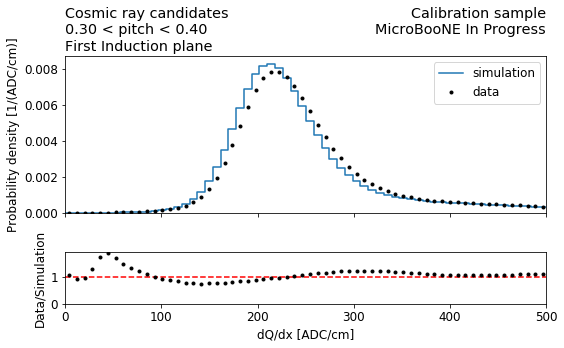

In [16]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=0,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[0.35],
                        add_to_title='Calibration sample',
                        axis_label='dqdx')
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig(save_folder+'plane_0_pitch_035.png', dpi=250)

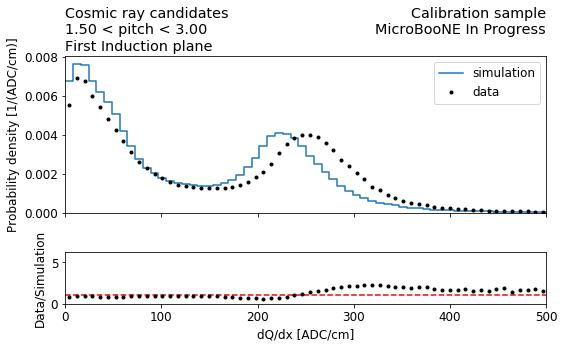

In [17]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=0,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[1.6],
                        add_to_title='Calibration sample',
                        axis_label='dqdx')
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig(save_folder+'plane_0_pitch_16.png', dpi=250)

## Calibration only mu

In [18]:
def scale_calibration(mu, dedx):
    return dedx * mu[0]

In [19]:
caloLike_calibration.setCalibrationFunction(calibration_function=scale_calibration, 
                                n_calibration_parameters=1)

/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


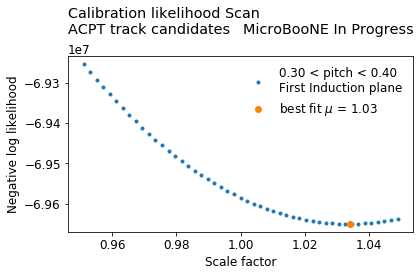

In [20]:
#example
caloLike_calibration.calibrationLikelihoodProfile(plane_num=0, 
                                                  parameters_value=[0.35], 
                                                  pdg_code=13, 
                                                  start_point=[1],
                                                  data_selection='default', 
                                                  plot=True,
                                                  mu_binnings=[[0.95, 1.05, 50]])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
# plt.savefig(save_folder+'plane_2_pitch_0.75.png', dpi=250)

In [21]:
mu_scan_binning = [[0.9, 1.15, 50]]
for plane in [0, 1, 2]:
    caloLike_calibration.buildCalibrationTable(mu_scan_binning=mu_scan_binning, 
                          plane_num=plane, 
                          pdg_code=13, 
                          start_point=[1],
                          data_selection='default', 
                          plot_folder=save_folder_calibration+'plane{}/'.format(plane))

/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  Ru

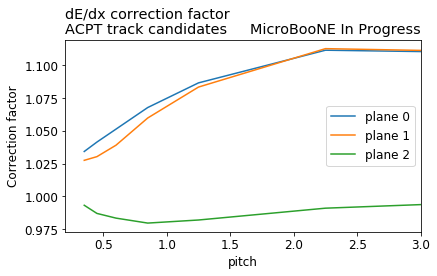

In [22]:
caloLike_calibration.plotCalibration1d()
plt.xlim(0.2, 3)
plt.savefig(save_folder_calibration+'calibration_table1d.png', dpi=200)

In [23]:
#print table
# caloLike_calibration.printCplusplusCorrection(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_correction_lookup.h', planes=[0, 1, 2])

In [24]:
# dump calibration object
caloLike_calibration.save(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch_only.dat')

## Plot pdf before and after - train set

In [25]:
load_calibration = False

In [26]:
caloLike_calibration2 = caloLikelihood(array_mc_train, quality_mask=muon_train, quality_masks_planes=mc_train_planes)
caloLike_calibration2.setCalibrationFunction(calibration_function=scale_calibration, 
                                n_calibration_parameters=1)
if load_calibration:
    filename = '/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch_only.dat'
    caloLikelihood_load = caloLikelihood(None)
    caloLikelihood_load.load(filename)
    caloLike_calibration2.calibration_table = caloLikelihood_load.calibration_table
elif ~load_calibration:
    caloLike_calibration2.calibration_table = caloLike_calibration.calibration_table
else:
    print("you need to set load calibration")

In [27]:
caloLike_calibration2.setPdgCodeVar(pdgcode_var)
    
for i_pl, name_plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    print(i_pl)
    this_parameters = [par+name_plane for par in parameters]
    caloLike_calibration2.setVariablesBinning(i_pl, this_parameters, parameters_bin_edges, dedx_vars+name_plane, dedx_bins, parameters_legend_names)
    caloLike_calibration2.buildLookUpTableMC(i_pl, 13, cali=True)

0
1
2


In [28]:
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_calibration.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        calibration_index = caloLike_calibration.findLookUpRow(plane_num, bin_center)
        for plot in ['data_mc', 'data_mc_cali']:
            fig, ax = plt.subplots(ncols=1,
                                           nrows=2,
                                           figsize=(6.5, 5),
                                           sharex='col',
                                           gridspec_kw={'height_ratios': [3, 1]})

            plt.sca(ax[0])
        
            if plot == 'data_mc':
                bin_contents_mc = caloLike_calibration.plotLookUpDedxMCfancy(plane_num=plane_num,
                                pdg_code=13, 
                                parameters_value=bin_center,
                                title_left='Cosmic ray candidates\n', 
                                label='mc', 
                                axis_label='dqdx')
                
            elif plot == 'data_mc_cali':
                bin_contents_mc = caloLike_calibration.plotLookUpDedxMC(plane_num=plane_num,
                                        pdg_code=13, 
                                        parameters_value=bin_center, 
                                        label='mc', 
                                        axis_label='dqdx')
                mu = caloLike_calibration.calibration_table[plane_num][calibration_index]
                bin_contents_mc_cali = caloLike_calibration2.plotLookUpDedxMCfancy(plane_num=plane_num,
                                        pdg_code=13, 
                                        parameters_value=bin_center,
                                        title_left='Cosmic ray candidates\n', 
                                        label='mc corrected\n$\mu$ = {:.3g}'.format(mu[0]), 
                                        axis_label='dqdx')

            bin_contents_data = caloLike_calibration.plotLookUpDedxData(plane_num=plane_num,
                                    data_selection='default', 
                                    parameters_value=bin_center, 
                                    axis_label='dqdx')

            plt.title('Train set\n\nMicroBooNE in Progress', loc='right')
            dedx_bins_centers = caloLike_calibration.dedx_bins_centers[plane_num]
            dedx_bins_edges = caloLike_calibration.dedx_bin_edges[plane_num]
            plt.legend()
            plt.xlabel('')
            plt.xlim(0, 500)
            plt.sca(ax[1])
            plt.plot(dedx_bins_centers, bin_contents_data/bin_contents_mc, '.', label='mc')
            if plot == 'data_mc_cali':
                plt.plot(dedx_bins_centers, bin_contents_data/bin_contents_mc_cali, '.', label=r'mc corrected')
            plt.plot([dedx_bins_edges[0], dedx_bins_edges[-1]], [1, 1], '--k', alpha=0.3)
            plt.ylim(0.5, 2)
            plt.xlabel('dQ/dx [ADC/cm]')
            plt.ylabel('Data/Simulation')
            plt.tight_layout()
            if plot == 'data_mc':
                this_save_folder = save_folder_data_mc
            elif plot == 'data_mc_cali':
                this_save_folder = save_folder_data_mc_cali
            plt.savefig(this_save_folder + 'plane{}/pitch_{:2.2f}'.format(plane_num, bin_center[0]).replace('.', '')+'.png', dpi=250)
            plt.savefig(this_save_folder + 'plane{}/pitch_{:2.2f}'.format(plane_num, bin_center[0]).replace('.', '')+'.pdf')
            plt.close()

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value